# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains multiple tasks to be completed, some require written answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload both this ipynb file and the PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

torch.cuda.is_available()

False

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [3]:
with open("wordlist.txt", "r", encoding="utf-8") as f:
    words = [w.strip().lower() for w in f if w.strip()]

filtered_words = [w for w in words if 4 < len(w) <= WORD_SIZE]
vocab = [w.ljust(WORD_SIZE, "_") for w in filtered_words]

len(vocab)

7720

<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer**
Limiting the vocabulary to words longer than 3 letters and shorter than a fixed maximum keeps training practical and efficient. Very short words add little predictive value, while very long ones increase sequence length, memory use, and padding overhead, slowing training and introducing outliers. By focusing on typical word lengths, the RNN processes more consistent data, converges faster, and generalizes better for autocompletion without wasting resources.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [4]:
def char_to_num(char):
    if char == "_":
        return 0
    return ord(char) - ord('a') + 1

def num_to_char(num):
    if num == 0:
        return "_"
    return chr(ord('a') + num - 1)

def word_to_numlist(word):
    return torch.tensor([char_to_num(c) for c in word], dtype=torch.long)

def numlist_to_word(numlist):
    return ''.join(num_to_char(int(n)) for n in numlist)

<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font> (write answers in the cell below as a string)

In [5]:
#Write answer here as strings:

answer_ = "Yes, the claim is valid. Converting letters to numbers based on alphabetical order introduces artificial ordinal relationships that don't exist between categories. For example, in the mapping 'a' -> 1, 'b' -> 2, 'z' -> 26, the model may incorrectly assume that 'z' is 'larger' or more similar to 'y' than to 'a', which has no meaningful basis in language. This is a common problem with categorical data encoding. An embedding layer is a trainable layer in a neural network that maps discrete input tokens (like characters or words) to dense, continuous vectors. Its purpose is to represent categorical data in a way that captures semantic meaning and relationships: instead of treating inputs as arbitrary indices, the embedding layer learns feature-rich representations where similar items are placed closer together in vector space. This makes it easier for the model to detect patterns and generalize effectively, completely solving the ordinal encoding problem."

## Section 2: Implementing the Autocomplete model

We will implement a RNN LSTM model. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [6]:
LEARNING_RATE = 0.005

In [7]:
class autocompleteModel(nn.Module):
    
    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers=1):
        super().__init__()

        #Set the input parameters to self parameters
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation
        self.embedding = nn.Embedding(alphabet_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, alphabet_size)

        self.to(self.device)

    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        #2. Feed the embedded output to the LSTM cell
        #3. Feed the LSTM output to the fully connected layer to obtain the output
        #4. return the output, and both the hidden state and cell state from the LSTM cell output

        x = character.view(1, 1).to(self.device)
        emb = self.embedding(x)
        lstm_out, (h, c) = self.lstm(emb, (hidden_state, cell_state))
        logits = self.fc(lstm_out.squeeze(0).squeeze(0))
        return logits, h, c

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self, batch_size=1):
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        
        return (h0, c0)

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs=5, batch_size=100):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters and learning rate
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        #Pre-tensorize vocab once
        vocab_tensors = torch.stack([word_to_numlist(w) for w in vocab]).to(self.device)  # (N, WORD_SIZE)
        N = vocab_tensors.size(0)
        num_iter = math.ceil(N / batch_size)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        for e in range(epochs):
            epoch_loss = []

            #TODO: Shuffle the vocab list the start of each epoch
            perm = torch.randperm(N, device=self.device)
            vocab_shuffled = vocab_tensors[perm]

            for i in range(num_iter):
                start = i * batch_size
                end = min((i + 1) * batch_size, N)
                batch = vocab_shuffled[start:end]

                inputs  = batch[:, :-1].long()
                targets = batch[:,  1:].long()

                optimizer.zero_grad()
                emb = self.embedding(inputs)
                lstm_out, _ = self.lstm(emb)
                logits = self.fc(lstm_out)
                loss = criterion(logits.reshape(-1, self.alphabet_size),
                                 targets.reshape(-1))
                loss.backward()
                optimizer.step()

                loss_log.append(loss.detach().item())
                epoch_loss.append(loss.detach().item())

            # quick sanity check each epoch
            print(f"Epoch {e + 1}/{epochs}  ----  Avg Loss: {(sum(epoch_loss) / len(epoch_loss)):.4f}")
            
        if len(loss_log) > 1:
            plt.figure()
            plt.plot(loss_log)
            plt.xlabel("Training step (batches)")
            plt.ylabel("Avg cross-entropy loss")
            plt.title("Training loss")
            plt.show()

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample, temperature = 0.3, greedy=True):

        #Convert the model into evaluation mode
        self.eval()
        completed_list = []

        #TODO: In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial 
        with torch.no_grad():
            for literal in sample:
                # clamp prefix length and lowercase
                prefix = (literal or "").lower()[:WORD_SIZE]
    
                # initialize hidden and cell states
                h, c = self.initial_state(1)
                logits = None
    
                # warm-up the LSTM with the known prefix
                for ch in prefix:
                    x = torch.tensor(char_to_num(ch), device=self.device).long()
                    logits, h, c = self.forward(x, h, c)
    
                generated = list(prefix)
    
                # predict remaining characters up to WORD_SIZE
                for _ in range(WORD_SIZE - len(prefix)):
                    # if we already produced an underscore, keep padding underscores
                    if len(generated) > 0 and generated[-1] == "_":
                        x = torch.tensor(char_to_num("_"), device=self.device).long()
                        logits, h, c = self.forward(x, h, c)
                        generated.append("_")
                        continue
    
                    # if no logits yet (empty prefix), seed with underscore
                    if logits is None:
                        x = torch.tensor(char_to_num("_"), device=self.device).long()
                        logits, h, c = self.forward(x, h, c)
    
                    if greedy:
                        idx = torch.argmax(logits, dim=-1)
                    else:
                        probs = torch.softmax(logits / temperature, dim=-1)
                        idx = torch.multinomial(probs, 1)
                    ch = num_to_char(int(idx.item()))
                    generated.append(ch)
    
                    # feed sampled char back in
                    logits, h, c = self.forward(idx.long().to(self.device), h, c)
    
                completed_list.append(''.join(generated))
                
        return(completed_list)

    def evaluate(self, test_samples):
        try:
            completions = self.autocomplete(test_samples)
            score = 0
            print("Results:")
            for sample, completion in zip(test_samples, completions):
                clean_completion = completion.rstrip('_')
                sample_score = 1 if any(word.rstrip('_').lower() == clean_completion.lower()
                                        for word in vocab) else 0
                mark = " * Valid word in vocab" if sample_score else " ! Not a word in vocab"
                print(f"  '{sample}' -> '{clean_completion}' {mark}")
                score += sample_score
            return score, completions
        except Exception as e:
            print(f"Error during evaluation: {e}")
            return 0, []


## Section 3: Using and evaluating the model

(i) Initialize and train autocompleteModels using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can.

(ii) Evaluate it on different samples of partially filled in words to test your model. Eg: ["univ", "math", "neur", "engin"] etc.

(iii) Set your best model, to the variable best_model. This model will be tested against random inputs (3-4 starting strings of common English words). **This will be the main contributor for your score in this project**.

In [8]:
EMBED_DIM = 100
HIDDEN_SIZE = 128
LEARNING_RATE = 0.005
EPOCHS = 60
BATCH_SIZE = 128

test_samples = [
    "comp", "prog", "soft", "data", "algo", "code", "web", "net", "sys", "hack",
    "math", "calc", "stat", "phys", "chem", "biol", "theo", "exp", "res", "lab",
    "engin", "mech", "elec", "civil", "aero", "aut", "robo", "desi", "bui", "tool",
    "mana", "lead", "team", "proj", "plan", "str", "mark", "sale", "cust", "serv",
    "univ", "stud", "lear", "educ", "sch", "grad", "degr", "cour", "exam", "tes",
    "medi", "heal", "nur", "doct", "hosp", "drug", "ther", "tre", "diag", "surg",
    "arti", "des", "musi", "pain", "draw", "writ", "poet", "danc", "sin", "acto",
]

Training model
Epoch 1/60  ----  Avg Loss: 1.5827
Epoch 2/60  ----  Avg Loss: 1.2679
Epoch 3/60  ----  Avg Loss: 1.1904
Epoch 4/60  ----  Avg Loss: 1.1382
Epoch 5/60  ----  Avg Loss: 1.0940
Epoch 6/60  ----  Avg Loss: 1.0575
Epoch 7/60  ----  Avg Loss: 1.0220
Epoch 8/60  ----  Avg Loss: 0.9946
Epoch 9/60  ----  Avg Loss: 0.9664
Epoch 10/60  ----  Avg Loss: 0.9443
Epoch 11/60  ----  Avg Loss: 0.9213
Epoch 12/60  ----  Avg Loss: 0.8997
Epoch 13/60  ----  Avg Loss: 0.8804
Epoch 14/60  ----  Avg Loss: 0.8638
Epoch 15/60  ----  Avg Loss: 0.8474
Epoch 16/60  ----  Avg Loss: 0.8310
Epoch 17/60  ----  Avg Loss: 0.8200
Epoch 18/60  ----  Avg Loss: 0.8088
Epoch 19/60  ----  Avg Loss: 0.7957
Epoch 20/60  ----  Avg Loss: 0.7839
Epoch 21/60  ----  Avg Loss: 0.7734
Epoch 22/60  ----  Avg Loss: 0.7662
Epoch 23/60  ----  Avg Loss: 0.7560
Epoch 24/60  ----  Avg Loss: 0.7464
Epoch 25/60  ----  Avg Loss: 0.7409
Epoch 26/60  ----  Avg Loss: 0.7328
Epoch 27/60  ----  Avg Loss: 0.7262
Epoch 28/60  ----  Avg

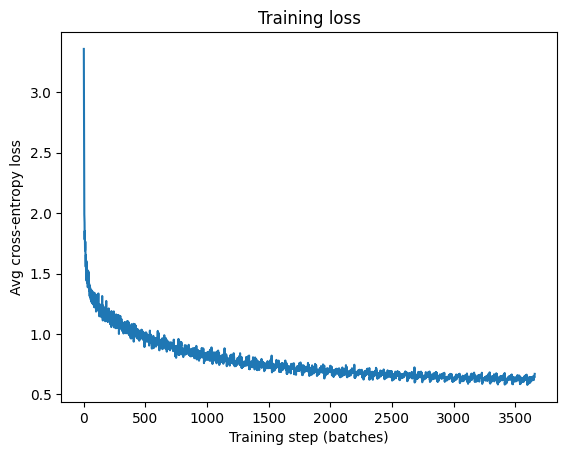


Evaluating model
Results:
  'comp' -> 'companies'  * Valid word in vocab
  'prog' -> 'programmer'  * Valid word in vocab
  'soft' -> 'soft'  ! Not a word in vocab
  'data' -> 'database'  * Valid word in vocab
  'algo' -> 'algorithm'  * Valid word in vocab
  'code' -> 'codes'  * Valid word in vocab
  'web' -> 'webcam'  * Valid word in vocab
  'net' -> 'networking'  * Valid word in vocab
  'sys' -> 'system'  * Valid word in vocab
  'hack' -> 'hacker'  * Valid word in vocab
  'math' -> 'mathematic'  ! Not a word in vocab
  'calc' -> 'calculation'  * Valid word in vocab
  'stat' -> 'state'  * Valid word in vocab
  'phys' -> 'physicial'  ! Not a word in vocab
  'chem' -> 'chemical'  * Valid word in vocab
  'biol' -> 'biological'  * Valid word in vocab
  'theo' -> 'theoret'  ! Not a word in vocab
  'exp' -> 'expense'  * Valid word in vocab
  'res' -> 'respondents'  * Valid word in vocab
  'lab' -> 'label'  * Valid word in vocab
  'engin' -> 'engineer'  * Valid word in vocab
  'mech' -> 'mec

In [9]:
model = autocompleteModel(
    alphabet_size=27,
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE
)

print("Training model")
model.trainModel(vocab, epochs=EPOCHS, batch_size=BATCH_SIZE)

print("\nEvaluating model")
score, completions = model.evaluate(test_samples)

print(f"\nTotal Score obtained---------------: {score}/{len(test_samples)}")
print(f"Average Score per Sample-----------: {score/len(test_samples):.2f}")

In [10]:
best_model = model